In [1]:
%load_ext autoreload

In [51]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import enum

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [54]:
class AggregationStrategy(enum.Enum):
    """This identifies the strategy used to deal with overlaping probabilities."""
    average_probabilities = 0

In [60]:
agg_strategy = 0 
agg_strategy = AggregationStrategy(agg_strategy)

In [3]:
def get_seconds_2by2(now: float) -> str:
    return ".".join(re.findall(".?.", str(int(now))))

logger.info(f"{(execution_name := get_seconds_2by2(exec_time := time.time()))=}")

[2020-10-30::13:57:39.960] tomo2seg :: INFO :: {<ipython-input-3-86518d59b7e8>:<module>:004}
(execution_name := get_seconds_2by2(exec_time := time.time()))='16.04.06.26.59'



In [4]:
logger.setLevel(logging.DEBUG)

In [2]:
volume = Volume.with_check(tomo2seg_data.VOLUME_PRECIPITATES_DRYRUN, "val")
logger.info(f"{volume=}")

NameError: name 'Volume' is not defined

In [6]:
# prefill the function `HST_read`
_hst_read = functools.partial(
    # from pymicro
    file_utils.HST_read,
    
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = copy.copy(volume.metadata.labels)

class labels:
    matrix = 0
    fiber = 1
    hole = 2

    
# this will later be useful when i transform this in python script
debug__save_figs = True
debug__save_crops_coordinates = True
debug__materialize_crops = False
figs_dir = volume.dir / f"process-volume.execution={execution_name}.debug-figs"

random_state = 42
random_state = np.random.RandomState(random_state)

batch_size = 32

probabilities_dtype = np.float16

In [48]:
save_probas_by_class = True

In [7]:
if debug__save_figs:
    logger.debug(f"Creating debug figs directory: {figs_dir=}")
    figs_dir.mkdir(exist_ok=True)

[2020-10-30::13:57:40.204] tomo2seg :: DEBUG :: {<ipython-input-7-4455809da031>:<module>:002}
Creating debug figs directory: figs_dir=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/process-volume.execution=16.04.06.26.59.debug-figs')



In [8]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy()  # todo add strategy to metadata

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)



## Validation volume

In [9]:
data_volume = hst_read(volume.data_path)
logger.debug(f"{data_volume.shape=}")

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
[2020-10-30::13:57:40.821] tomo2seg :: DEBUG :: {<ipython-input-9-b7176a818869>:<module>:002}
data_volume.shape=(500, 500, 500)



In [10]:
def crop_coord2data(coordinates: ndarray, data: ndarray) -> ndarray:
    """
    coordinates: 3x2
    data: W x H x D
    """
    (x0, x1), (y0, y1), (z0, z1) = coordinates
    return data[x0:x1, y0:y1, z0:z1]


crop_coord2data__data_loaded = functools.partial(crop_coord2data, data=data_volume)

# Model

In [11]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)

In [12]:
with mirrored_strategy.scope():
    model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

In [13]:
with mirrored_strategy.scope():
    in_ = model.layers[0]
    in_shape = in_.input_shape[0]

    logger.debug(f"{(input_n_channels := in_shape[-1:])=}")

    anysize_input = layers.Input(
        shape=[None, None] + list(input_n_channels),
        name="input_any_image_size"
    )

    model.layers[0] = anysize_input

[2020-10-30::13:57:44.447] tomo2seg :: DEBUG :: {<ipython-input-13-6a48ca763ba9>:<module>:005}
(input_n_channels := in_shape[-1:])=(1,)



# Processing

In [14]:
# it has to be multiple of 16 because of the 4 cascaded 2x2-strided 2x2-downsamplings in u-net
xy_dims_multiple_16 = [int(16 * np.floor(dim / 16)) for dim in volume.metadata.dimensions[:2]]
logger.debug(f"{xy_dims_multiple_16=}")

crop_shape = tuple(xy_dims_multiple_16 + [1])  # x-axis, y-axis, z-axis
volume_shape = data_volume.shape

logger.debug(f"{crop_shape=}   {volume_shape=}")

n_steps = tuple(
    int(np.ceil(vol_dim / crop_dim))
    for vol_dim, crop_dim in zip(volume_shape, crop_shape)
)
logger.debug(f"{n_steps=}")

def get_coordinates_iterator(n_steps_):
    assert len(n_steps_) == 3
    return itertools.product(*(range(n_steps_[dim]) for dim in range(3)))

get_ijk_iterator = functools.partial(
    get_coordinates_iterator, copy.copy(n_steps)
)

get_kji_iterator = functools.partial(
    get_coordinates_iterator, tuple(reversed(n_steps))
)

# coordinates (xs, ys, and zs) of the front upper left corners of the crops
x0s, y0s, z0s = tuple(
    tuple(map(
        int, 
        np.linspace(0, vol_dim - crop_dim, n)
    ))
    for vol_dim, crop_dim, n in zip(volume_shape, crop_shape, n_steps)
)
logger.debug(f"""{min(x0s)=}, {max(x0s)=}, {len(x0s)=}
{min(y0s)=}, {max(y0s)=}, {len(y0s)=}
{min(z0s)=}, {max(z0s)=}, {len(z0s)=}
""")

[2020-10-30::13:57:44.506] tomo2seg :: DEBUG :: {<ipython-input-14-0d701cd4dcc5>:<module>:003}
xy_dims_multiple_16=[496, 496]

[2020-10-30::13:57:44.507] tomo2seg :: DEBUG :: {<ipython-input-14-0d701cd4dcc5>:<module>:008}
crop_shape=(496, 496, 1)   volume_shape=(500, 500, 500)

[2020-10-30::13:57:44.508] tomo2seg :: DEBUG :: {<ipython-input-14-0d701cd4dcc5>:<module>:014}
n_steps=(2, 2, 500)

[2020-10-30::13:57:44.511] tomo2seg :: DEBUG :: {<ipython-input-14-0d701cd4dcc5>:<module>:036}
min(x0s)=0, max(x0s)=4, len(x0s)=2
min(y0s)=0, max(y0s)=4, len(y0s)=2
min(z0s)=0, max(z0s)=499, len(z0s)=500




## Generate the crops

In [15]:
figs_common_metadata = dict(Author="joaopcbertoldo", CreationTime=str(int(exec_time)), Software="tomo2seg")
figs_common_kwargs = dict(bbox_inches="tight", format="png")

[2020-10-30::13:57:44.614] tomo2seg :: DEBUG :: {<ipython-input-16-11355a644e7c>:<module>:003}
Saving figure (fig_name := 'whole-volume.orthogonal-slices.png')='whole-volume.orthogonal-slices.png'

[2020-10-30::13:57:44.848] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:016}
volume.shape=(500, 500, 500)

[2020-10-30::13:57:44.850] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:020}
vmin, vmax=(0, 255)

[2020-10-30::13:57:44.851] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:025}
No label mask given.

[2020-10-30::13:57:44.852] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:037}
xy_z_coord, yz_x_coord, xz_y_coord=(250, 250, 250)

[2020-10-30::13:57:44.862] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:044}
xy_slice.shape, yz_slice.shape, xz_slice.shape=((500, 500), (500, 500), (500, 500))

[2020-10-30::13:57:47.210] tomo2seg :: DEBUG :: {<ipython-input-16-11355a644e7c>:<module>:019}
Saving figure (fig_name := 'whole-volume.orthogonal-slices-with-(x0s, y0s, z0

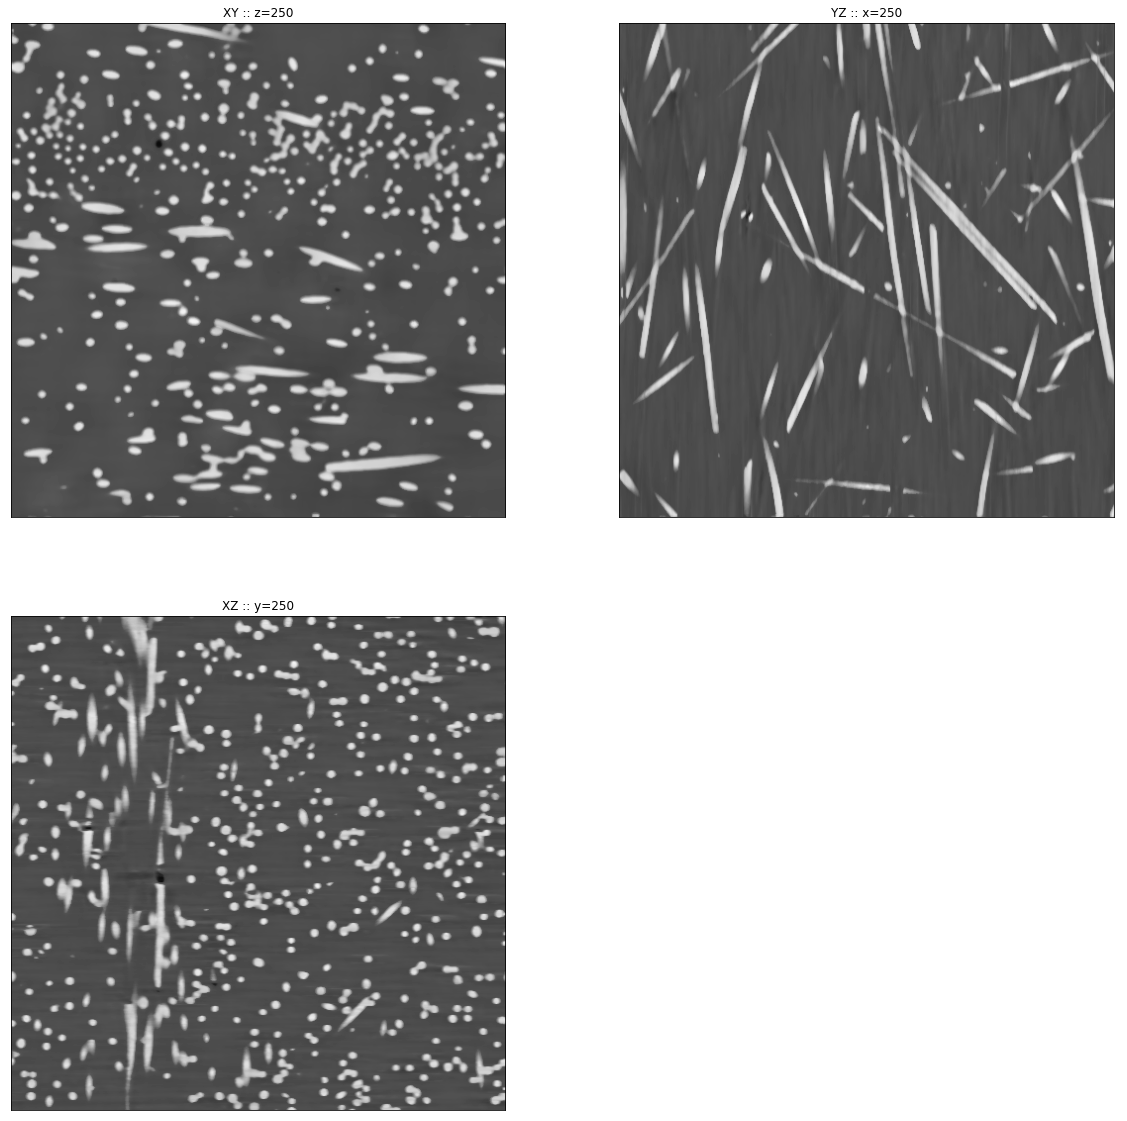

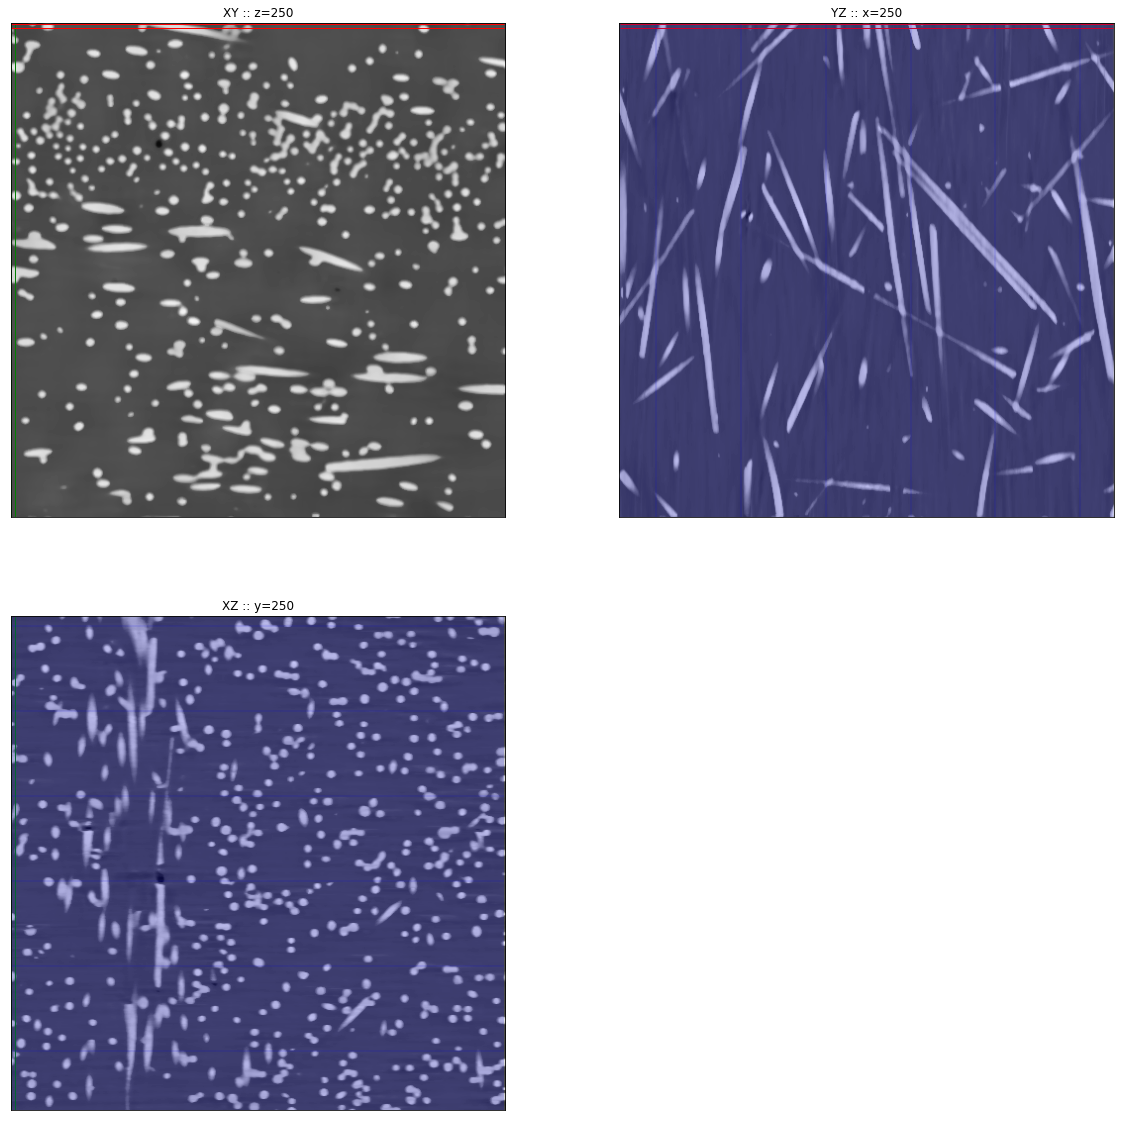

In [16]:
if debug__save_figs:
    
    logger.debug(f"Saving figure {(fig_name := 'whole-volume.orthogonal-slices.png')=}")
    fig, axs = plt.subplots(2, 2, figsize=(sz := 20, sz))
    viz.plot_orthogonal_slices(axs, data_volume)
    
    fig.savefig(
        fname=figs_dir / fig_name,
        dpi=200,
        **figs_common_kwargs,
        metadata={
            "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
            **figs_common_kwargs
        }
    )

    
if debug__save_figs:
    logger.debug(f"Saving figure {(fig_name := 'whole-volume.orthogonal-slices-with-(x0s, y0s, z0s).png')=}")
    fig, axs = plt.subplots(2, 2, figsize=(sz := 20, sz))
    viz.plot_orthogonal_slices(axs, data_volume)

    ax_xy, ax_yz, ax_xz = axs[0, 0], axs[0, 1], axs[1, 0]
    
    for x_ in x0s:
        ax_xy.vlines(x_, 0, volume_shape[0] - 1, color='g', linewidth=1)
        ax_xz.vlines(x_, 0, volume_shape[2] - 1, color='g', linewidth=1)

    for y_ in y0s:
        ax_xy.hlines(y_, 0, volume_shape[1] - 1, color='r', linewidth=1)
        ax_yz.hlines(y_, 0, volume_shape[2] - 1, color='r', linewidth=1)

    for z_ in z0s:
        ax_yz.vlines(z_, 0, volume_shape[0] - 1, color='b', linewidth=0.2)    
        ax_xz.hlines(z_, 0, volume_shape[1] - 1, color='b', linewidth=0.2)
    
    fig.savefig(
        fname=figs_dir / fig_name,
        dpi=200,
        **figs_common_kwargs,
        metadata={
            "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
            **figs_common_kwargs
        }
    )

In [17]:
logger.debug("Generating the crop coordinates.")

crops_coordinates = np.array(
    [
        (
            (x0, x0 + crop_shape[0]), 
            (y0, y0 + crop_shape[1]),
            (z0, z0 + crop_shape[2]),
        )
        for x0, y0, z0 in itertools.product(x0s, y0s, z0s)
    ], 
    dtype=tuple
).reshape(len(x0s), len(y0s), len(z0s), 3, 2).astype(int)  # 3 = nb of dimenstions, 2 = (start, end)

logger.debug(f"{crops_coordinates.shape=}\n{crops_coordinates[0, 0, 0]=} ")

if debug__save_crops_coordinates:
    logger.debug(f"Saving crops coordinates at {(coords_fname := volume.dir / f'process-volume.execution={execution_name}.crops-coordinates.npy')=}")
    np.save(coords_fname, crops_coordinates)

crops_coordinates_sequential = crops_coordinates.reshape(-1, 3, 2, order='F')  # 'F' reshapes with x varying fastest and z slowest

logger.debug(f"{crops_coordinates_sequential.shape=}\n{crops_coordinates_sequential[0]=} ")


[2020-10-30::13:57:53.492] tomo2seg :: DEBUG :: {<ipython-input-17-5f5f18a252be>:<module>:001}
Generating the crop coordinates.

[2020-10-30::13:57:53.503] tomo2seg :: DEBUG :: {<ipython-input-17-5f5f18a252be>:<module>:015}
crops_coordinates.shape=(2, 2, 500, 3, 2)
crops_coordinates[0, 0, 0]=array([[  0, 496],
       [  0, 496],
       [  0,   1]]) 

[2020-10-30::13:57:53.504] tomo2seg :: DEBUG :: {<ipython-input-17-5f5f18a252be>:<module>:018}
Saving crops coordinates at (coords_fname := volume.dir / f'process-volume.execution={execution_name}.crops-coordinates.npy')=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/process-volume.execution=16.04.06.26.59.crops-coordinates.npy')

[2020-10-30::13:57:53.508] tomo2seg :: DEBUG :: {<ipython-input-17-5f5f18a252be>:<module>:023}
crops_coordinates_sequential.shape=(2000, 3, 2)
crops_coordinates_sequential[0]=array([[  0, 496],
       [  0, 496],
       [  0,   1]]) 



[2020-10-30::13:57:53.562] tomo2seg :: DEBUG :: {<ipython-input-18-664762ddff8c>:<module>:002}
Saving figure (fig_name := 'one-z-slice-crops-locations.png')='one-z-slice-crops-locations.png'

[2020-10-30::13:57:53.675] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:016}
volume.shape=(500, 500, 1)

[2020-10-30::13:57:53.677] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:020}
vmin, vmax=(0, 255)

[2020-10-30::13:57:53.677] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:025}
No label mask given.

[2020-10-30::13:57:53.678] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:037}
xy_z_coord, yz_x_coord, xz_y_coord=(0, 250, 250)

[2020-10-30::13:57:53.683] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:044}
xy_slice.shape, yz_slice.shape, xz_slice.shape=((500, 500), (500, 1), (500, 1))



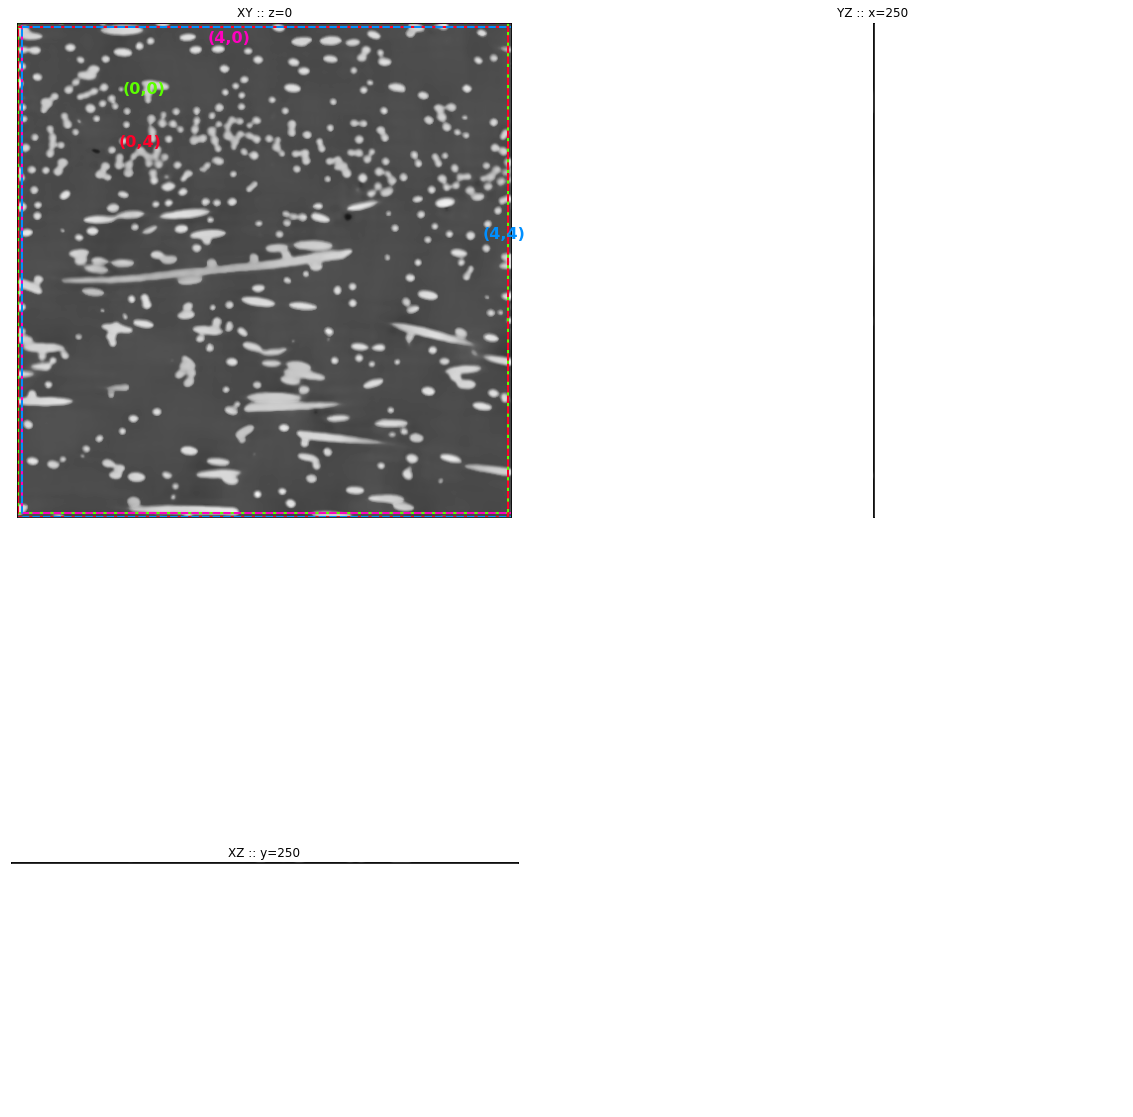

In [18]:
if debug__save_figs:
    logger.debug(f"Saving figure {(fig_name := 'one-z-slice-crops-locations.png')=}")    
    
    get_frame = functools.partial(
        patches.Rectangle,
        linewidth=2, facecolor='none', ls="--"
    )
    text_kwargs = dict(fontsize=16, fontweight='bold')
    
    # this is just a number beween 0 and 1 that represents
    # the percentage of the linear path in the color space
    rainbow = plt.get_cmap('gist_rainbow')

    # 3 slices with 3x3 crops
    colors = [rainbow(idx) for idx in np.linspace(0, 1, n_steps[0] * n_steps[1])]
    random_state.shuffle(colors)

    fig, axs = plt.subplots(2, 2, figsize=(sz := 20, sz))
    viz.plot_orthogonal_slices(axs, z_slice := data_volume[:, :, :1])
    ax_xy = axs[0, 0]

    for ((x0, x1), (y0, y1), (z0, z1)), color in zip(crops_coordinates_sequential, colors):
        frame = get_frame(
            xy := (x0, y0), width := x1 - x0, height := y1 - y0, edgecolor=color
        )
        ax_xy.add_patch(frame)
        ax_xy.text(
            random_state.randint(x0, x0 + width), 
            random_state.randint(y0, y0 + height), 
             f"({x0},{y0})", 
            color=color, 
            **text_kwargs
        )
    
    fig.savefig(
        fname=figs_dir / fig_name,
        dpi=200,
        **figs_common_kwargs,
        metadata={
            "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
            **figs_common_kwargs
        }
    )

In [19]:
if debug__materialize_crops:
    logger.debug(f"Extracting crops ({debug__materialize_crops=}).")
    
    crops_sequential = np.array([
        crop_coord2data__data_loaded(coords)
        for coords in crops_coordinates_sequential
    ])

    logger.debug(f"{crops_sequential.shape=}")

    crops_target_shape = list(crops_coordinates.shape[:3]) + list(crop_shape)

    logger.debug(f"{crops_target_shape=}")

    # 'F' reshapes with x varying fastest and z slowest
    # this option is necessary because `crops_coordinates` was reshaped with it
    crops = crops_sequential.reshape(crops_target_shape, order="F")

    logger.debug(f"{crops.shape=}")

[2020-10-30::13:57:55.278] tomo2seg :: DEBUG :: {<ipython-input-20-db52c062123f>:<module>:003}
Plotinng (n_crop_plots := 3)=3 examples of 3d crops.

[2020-10-30::13:57:55.280] tomo2seg :: DEBUG :: {<ipython-input-20-db52c062123f>:<module>:010}
(ijk := (i, j, k))=(0, 0, 0)

[2020-10-30::13:57:55.284] tomo2seg :: DEBUG :: {<ipython-input-20-db52c062123f>:<module>:016}
one_crop.shape=(496, 496, 1)

[2020-10-30::13:57:55.285] tomo2seg :: DEBUG :: {<ipython-input-20-db52c062123f>:<module>:018}
Saving figure (fig_name := f'crop-{ijk}.orthogonal-slices.png')='crop-(0, 0, 0).orthogonal-slices.png'

[2020-10-30::13:57:55.385] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:016}
volume.shape=(496, 496, 1)

[2020-10-30::13:57:55.386] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:020}
vmin, vmax=(0, 255)

[2020-10-30::13:57:55.387] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:025}
No label mask given.

[2020-10-30::13:57:55.391] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:

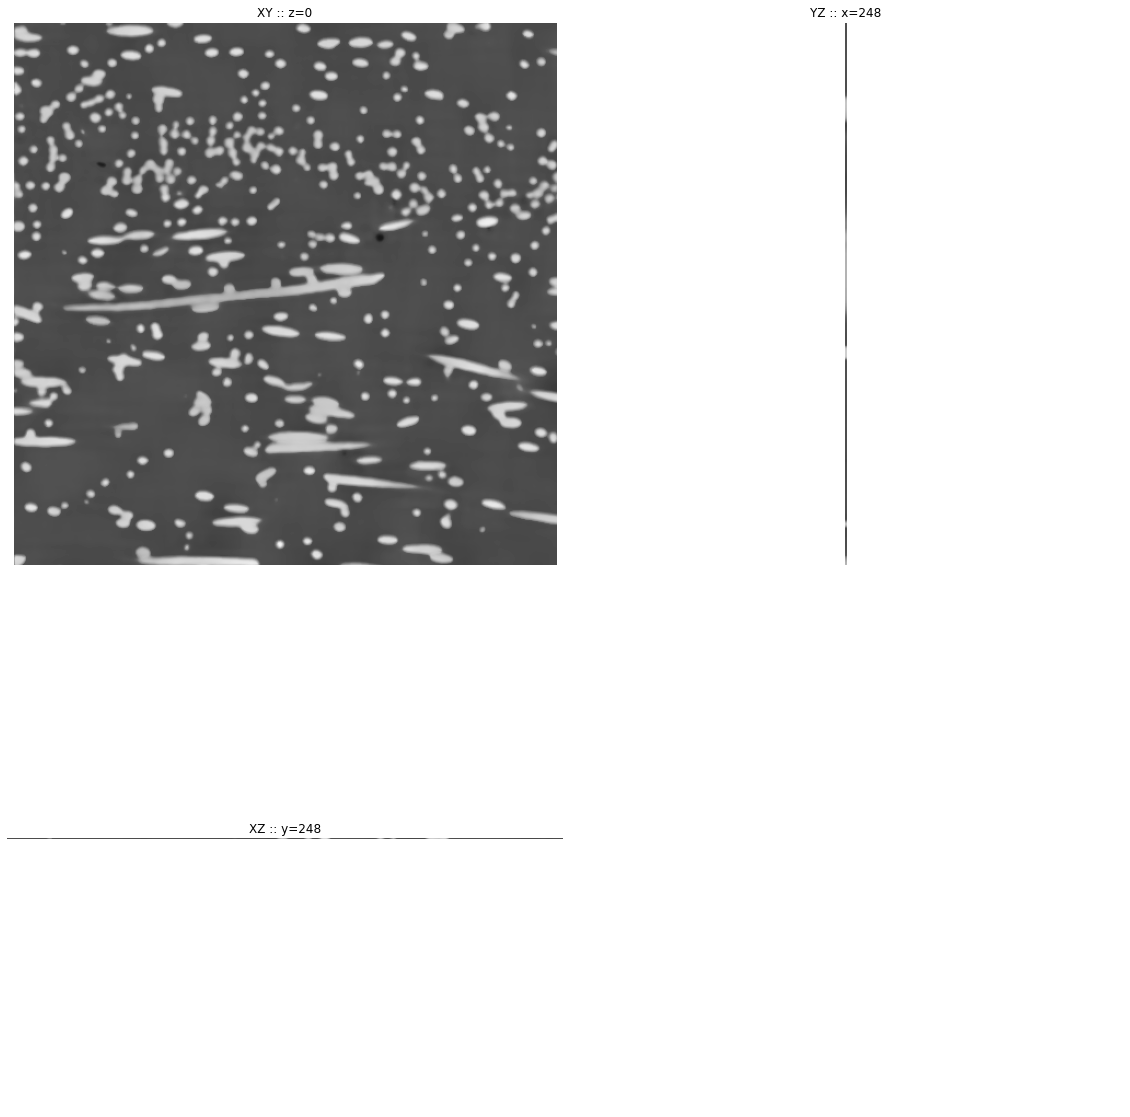

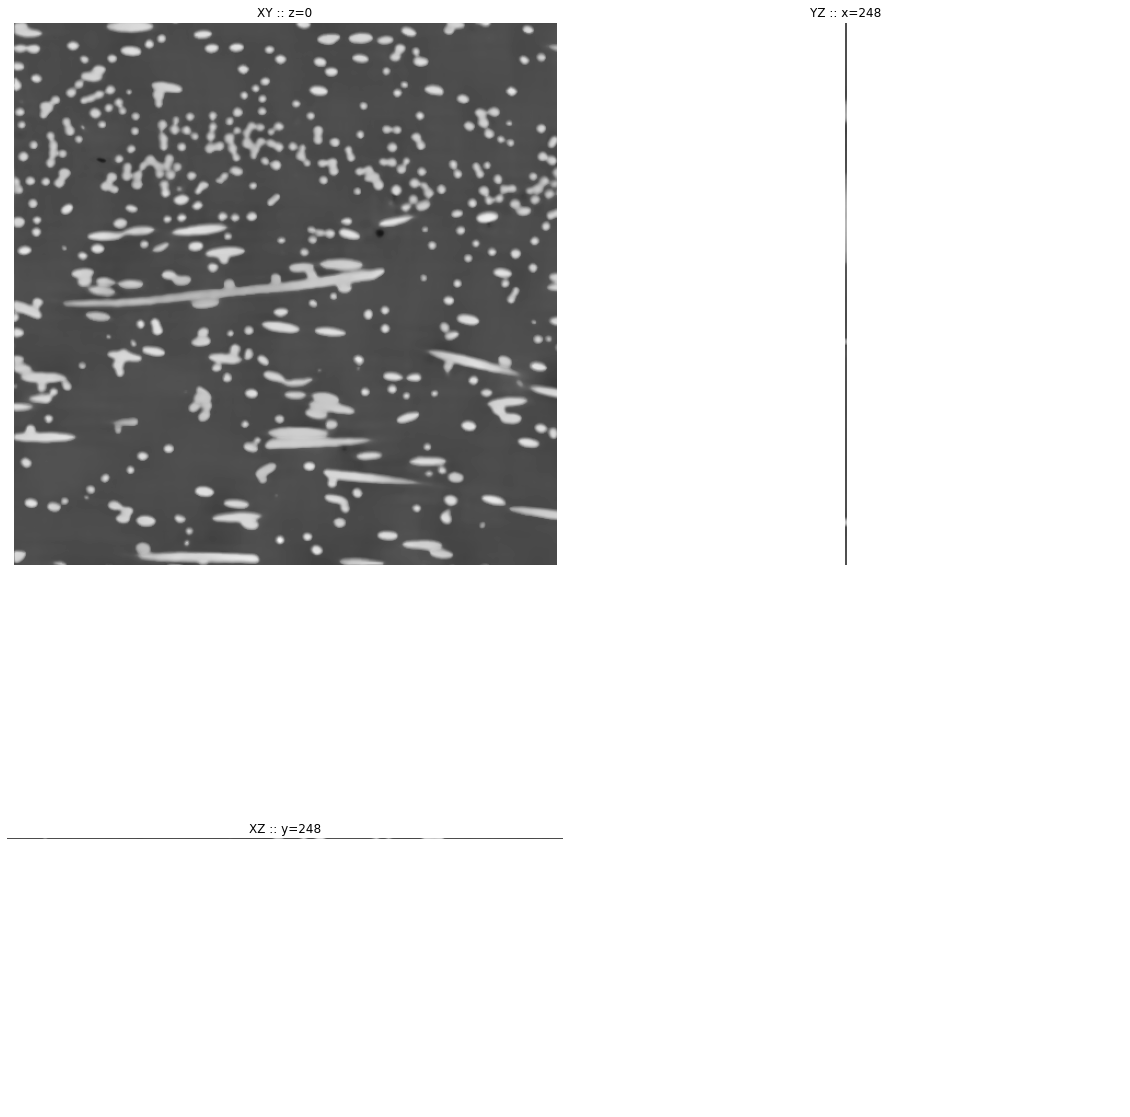

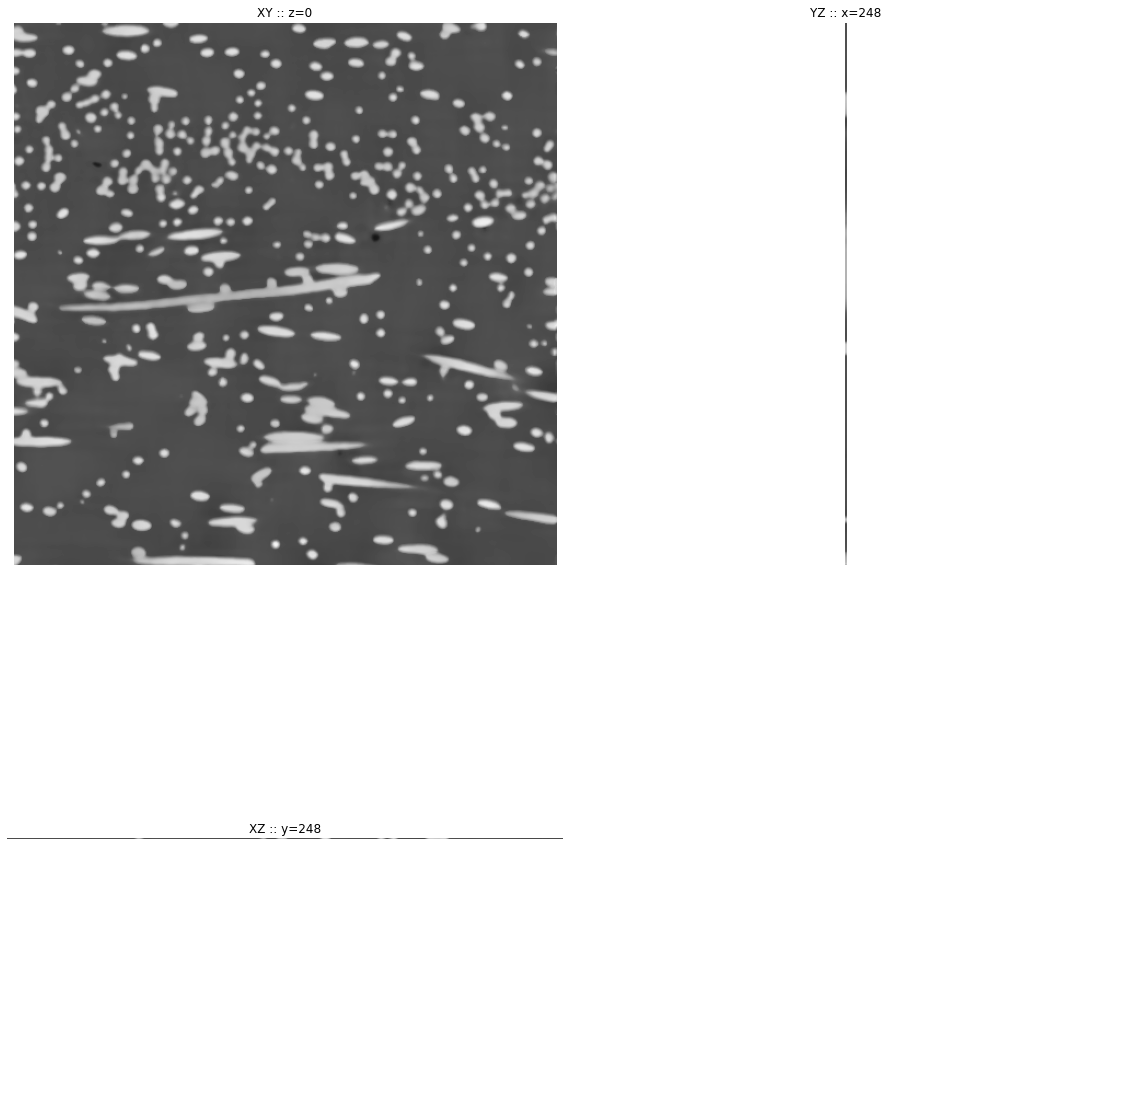

In [20]:
if debug__save_figs:

    logger.debug(f"Plotinng {(n_crop_plots := 3)=} examples of 3d crops.")
    
    for n, (k, j, i) in enumerate(get_kji_iterator()):
                
        if n >= n_crop_plots:
            break
            
        logger.debug(f"{(ijk := (i, j, k))=}")
        
        if debug__materialize_crops:
            one_crop = crops[i, j, k]
        else:
            one_crop = crop_coord2data__data_loaded(crops_coordinates[i, j, k])
        logger.debug(f"{one_crop.shape=}")
        
        logger.debug(f"Saving figure {(fig_name := f'crop-{ijk}.orthogonal-slices.png')=}")    

        fig, axs = plt.subplots(
            nrows=2, ncols=2,
            figsize=(sz := 20, sz), 
            gridspec_kw={"wspace": (gridspace := .01), "hspace": .5 * gridspace}
        )
        for ax in axs.ravel():
            ax.axis("off")
            
        viz.plot_orthogonal_slices(axs, one_crop)
        
        fig.savefig(
            fname=figs_dir / fig_name,
            dpi=200,
            **figs_common_kwargs,
            metadata={
                "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
                **figs_common_kwargs
            }
        )

## Segment

In [21]:
logger.debug(f"Segmenting one crop for debug {(crop_ijk := (0, 0, 0))=}")

if debug__materialize_crops:
    crop_data = crops[crop_ijk[0], crop_ijk[1], crop_ijk[2]]
else:
    crop_coordinates = crops_coordinates[crop_ijk[0], crop_ijk[1], crop_ijk[2]]
    crop_data = crop_coord2data__data_loaded(crop_coordinates)
    
logger.debug(f"{crop_data.shape=}")

# [model] - i call it with a first crop bc if something goes wrong then the error
# will appear here instead of in a loop

# modelin
modelin = crop_data.reshape(1, crop_shape[0], crop_shape[1], 1) / 255  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
logger.debug(f"{modelin.shape=}")

# modelout
modelout = model.predict(modelin, batch_size=1)
logger.debug(f"{modelout.shape=}")

logger.debug(f"{(n_classes := modelout.shape[-1])=}")

# probas
logger.debug(f"{(crop_probas_target_shape := list(crop_shape) + [n_classes])=}")
crop_probas = modelout.reshape(crop_probas_target_shape).astype(probabilities_dtype)

# preds
crop_preds = crop_probas.argmax(axis=-1)

[2020-10-30::13:57:59.067] tomo2seg :: DEBUG :: {<ipython-input-21-a8c816058e36>:<module>:001}
Segmenting one crop for debug (crop_ijk := (0, 0, 0))=(0, 0, 0)

[2020-10-30::13:57:59.069] tomo2seg :: DEBUG :: {<ipython-input-21-a8c816058e36>:<module>:009}
crop_data.shape=(496, 496, 1)

[2020-10-30::13:57:59.071] tomo2seg :: DEBUG :: {<ipython-input-21-a8c816058e36>:<module>:016}
modelin.shape=(1, 496, 496, 1)

[2020-10-30::13:58:02.891] tomo2seg :: DEBUG :: {<ipython-input-21-a8c816058e36>:<module>:020}
modelout.shape=(1, 496, 496, 3)

[2020-10-30::13:58:02.892] tomo2seg :: DEBUG :: {<ipython-input-21-a8c816058e36>:<module>:022}
(n_classes := modelout.shape[-1])=3

[2020-10-30::13:58:02.893] tomo2seg :: DEBUG :: {<ipython-input-21-a8c816058e36>:<module>:025}
(crop_probas_target_shape := list(crop_shape) + [n_classes])=[496, 496, 1, 3]



[2020-10-30::13:58:02.998] tomo2seg :: DEBUG :: {<ipython-input-22-4e247c58cd1c>:<module>:002}
Saving figure (fig_name := f'crop-{crop_ijk}.prediction.png')='crop-(0, 0, 0).prediction.png'



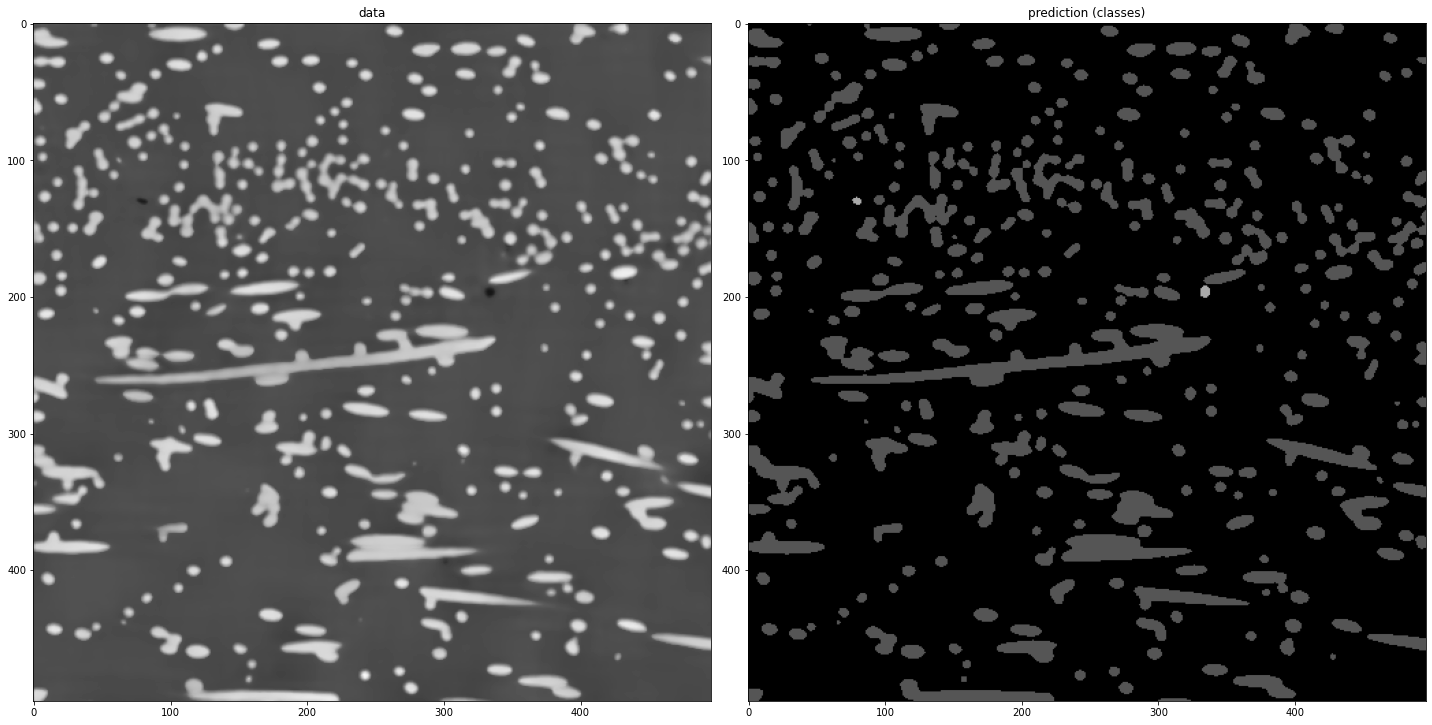

In [22]:
if debug__save_figs:
    logger.debug(f"Saving figure {(fig_name := f'crop-{crop_ijk}.prediction.png')=}")    
    
    fig, axs = plt.subplots(1, 2, figsize=(sz := 20, 2 * sz))
    fig.set_tight_layout(True)

    axs[0].imshow(crop_data, vmin=0, vmax=255, cmap=cm.gray)
    axs[0].set_title("data")
    
    axs[1].imshow(crop_preds, vmin=0, vmax=n_classes, cmap=cm.gray)
    axs[1].set_title("prediction (classes)")

    fig.savefig(
        fname=figs_dir / fig_name,
        dpi=200,
        **figs_common_kwargs,
        metadata={
            "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
            **figs_common_kwargs
        }
    )

In [23]:
if debug__materialize_crops:
    logger.debug(f"{(proba_crops_target_shape := list(crops.shape) + [n_classes])=}")

    proba_crops = np.empty(proba_crops_target_shape, dtype=probabilities_dtype)
    logger.debug(f"{proba_crops.shape=} {proba_crops.dtype=}")

    pred_crops = np.empty_like(crops)
    logger.debug(f"{pred_crops.shape=} {pred_crops.dtype=}")

    ijk_iterator = list(get_ijk_iterator())
    logger.debug(f"{(n_iterations := len(ijk_iterator))=}")

    for i, j, k in pbar(ijk_iterator, prefix="crops-segmentation", max_value=n_iterations):
    
        crop_data = crops[i, j, k]
        
        # [model]
        model_in = crop_data.reshape(1, crop_shape[0], crop_shape[1], crop_shape[2]) / 255
        model_out = model.predict(model_in)
        # todo save me for debug/analysis
        proba_crops[i, j, k] = model_out.reshape(crop_probas_target_shape).astype(probabilities_dtype)

        # todo save me for debug/analysis
        pred_crops[i, j, k] = proba_crops[i, j, k].argmax(axis=-1)

[2020-10-30::13:58:05.284] tomo2seg :: DEBUG :: {<ipython-input-24-9b9a2c3afcc8>:<module>:002}
Plotinng output probabilites of  (n_crop_plots := 1)=1 examples of 3d crops.

[2020-10-30::13:58:05.286] tomo2seg :: DEBUG :: {<ipython-input-24-9b9a2c3afcc8>:<module>:009}
(ijk := (i, j, k))=(0, 0, 0)

[2020-10-30::13:58:08.607] tomo2seg :: DEBUG :: {<ipython-input-24-9b9a2c3afcc8>:<module>:022}
probas.shape=(496, 496, 1, 3)

[2020-10-30::13:58:08.608] tomo2seg :: DEBUG :: {<ipython-input-24-9b9a2c3afcc8>:<module>:025}
Saving figure (fig_name := f'crop-{ijk}.probabilities.class={class_idx}.png')='crop-(0, 0, 0).probabilities.class=0.png'

[2020-10-30::13:58:08.697] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:016}
volume.shape=(496, 496, 1)

[2020-10-30::13:58:08.698] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:020}
vmin, vmax=(0, 1)

[2020-10-30::13:58:08.698] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:025}
No label mask given.

[2020-10-30::13:58:08.700] tomo2seg ::

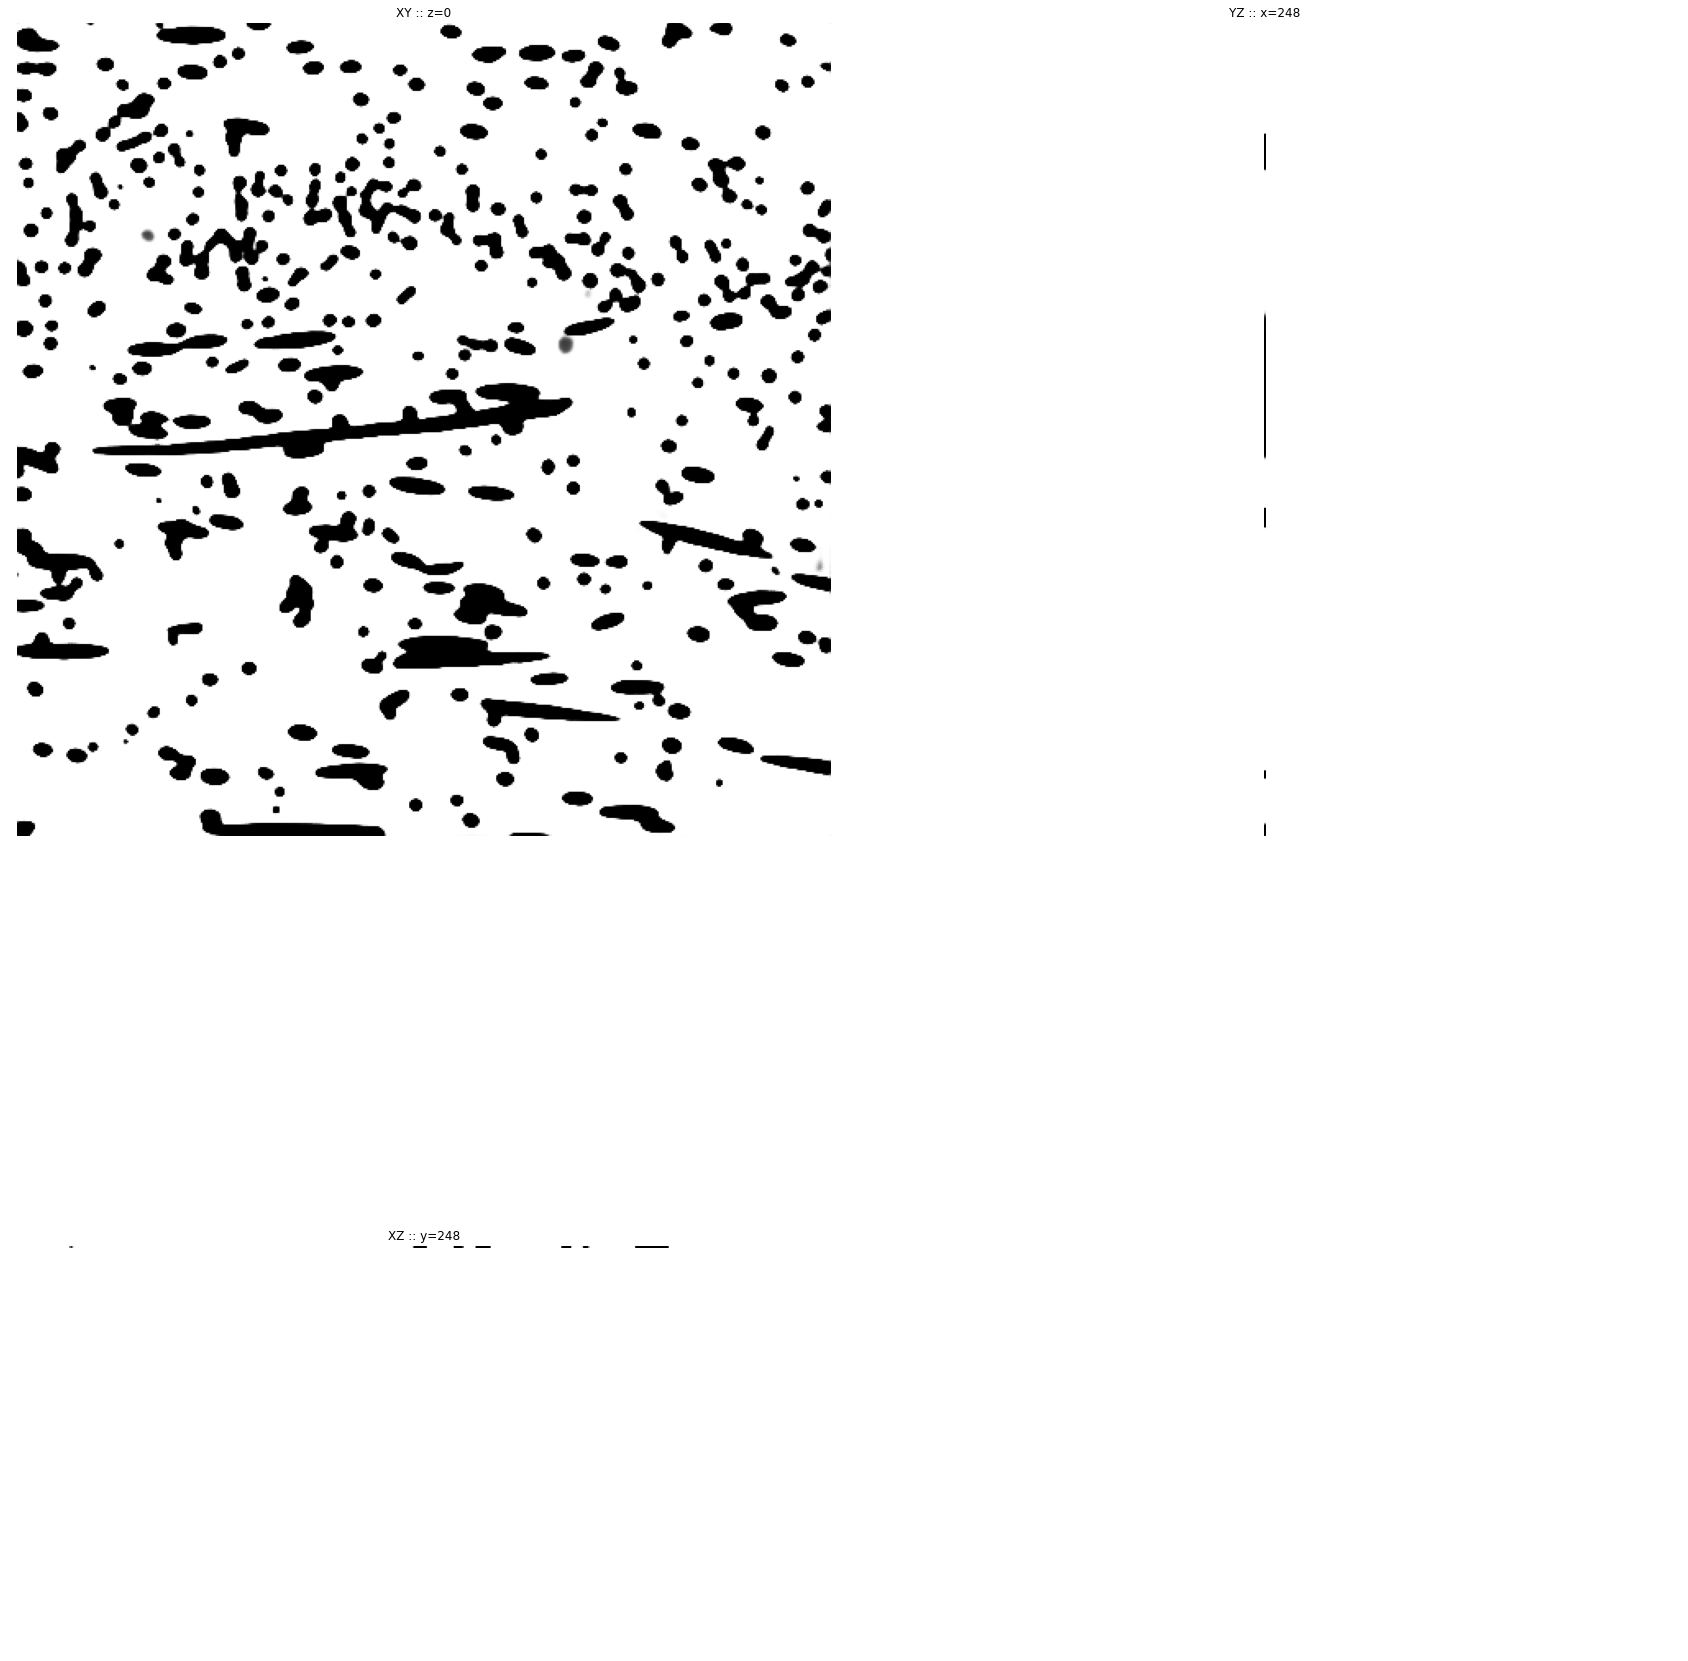

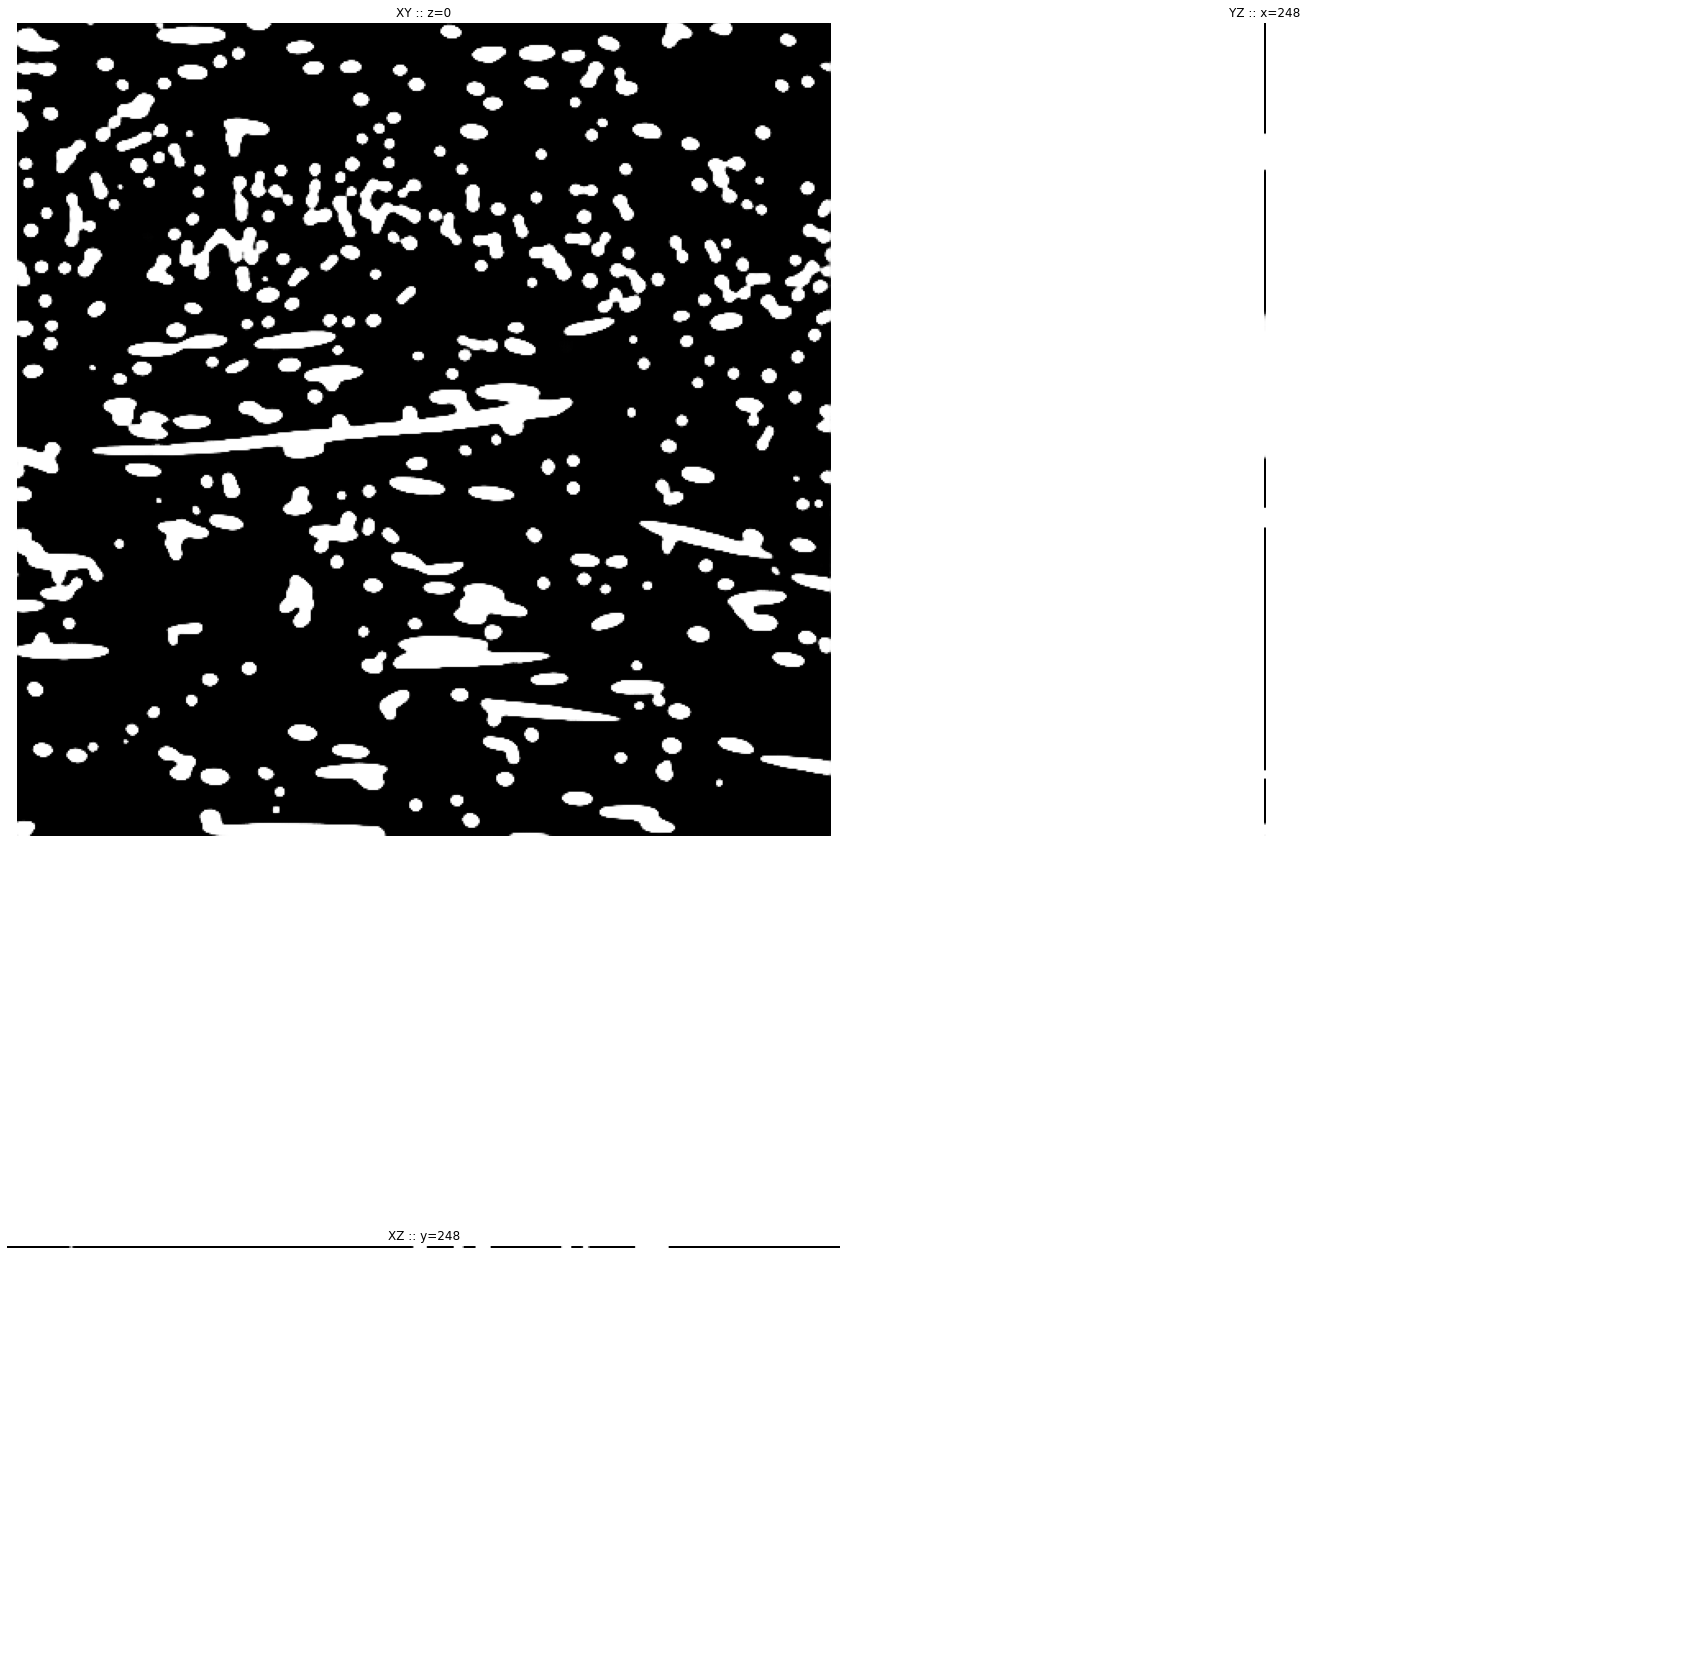

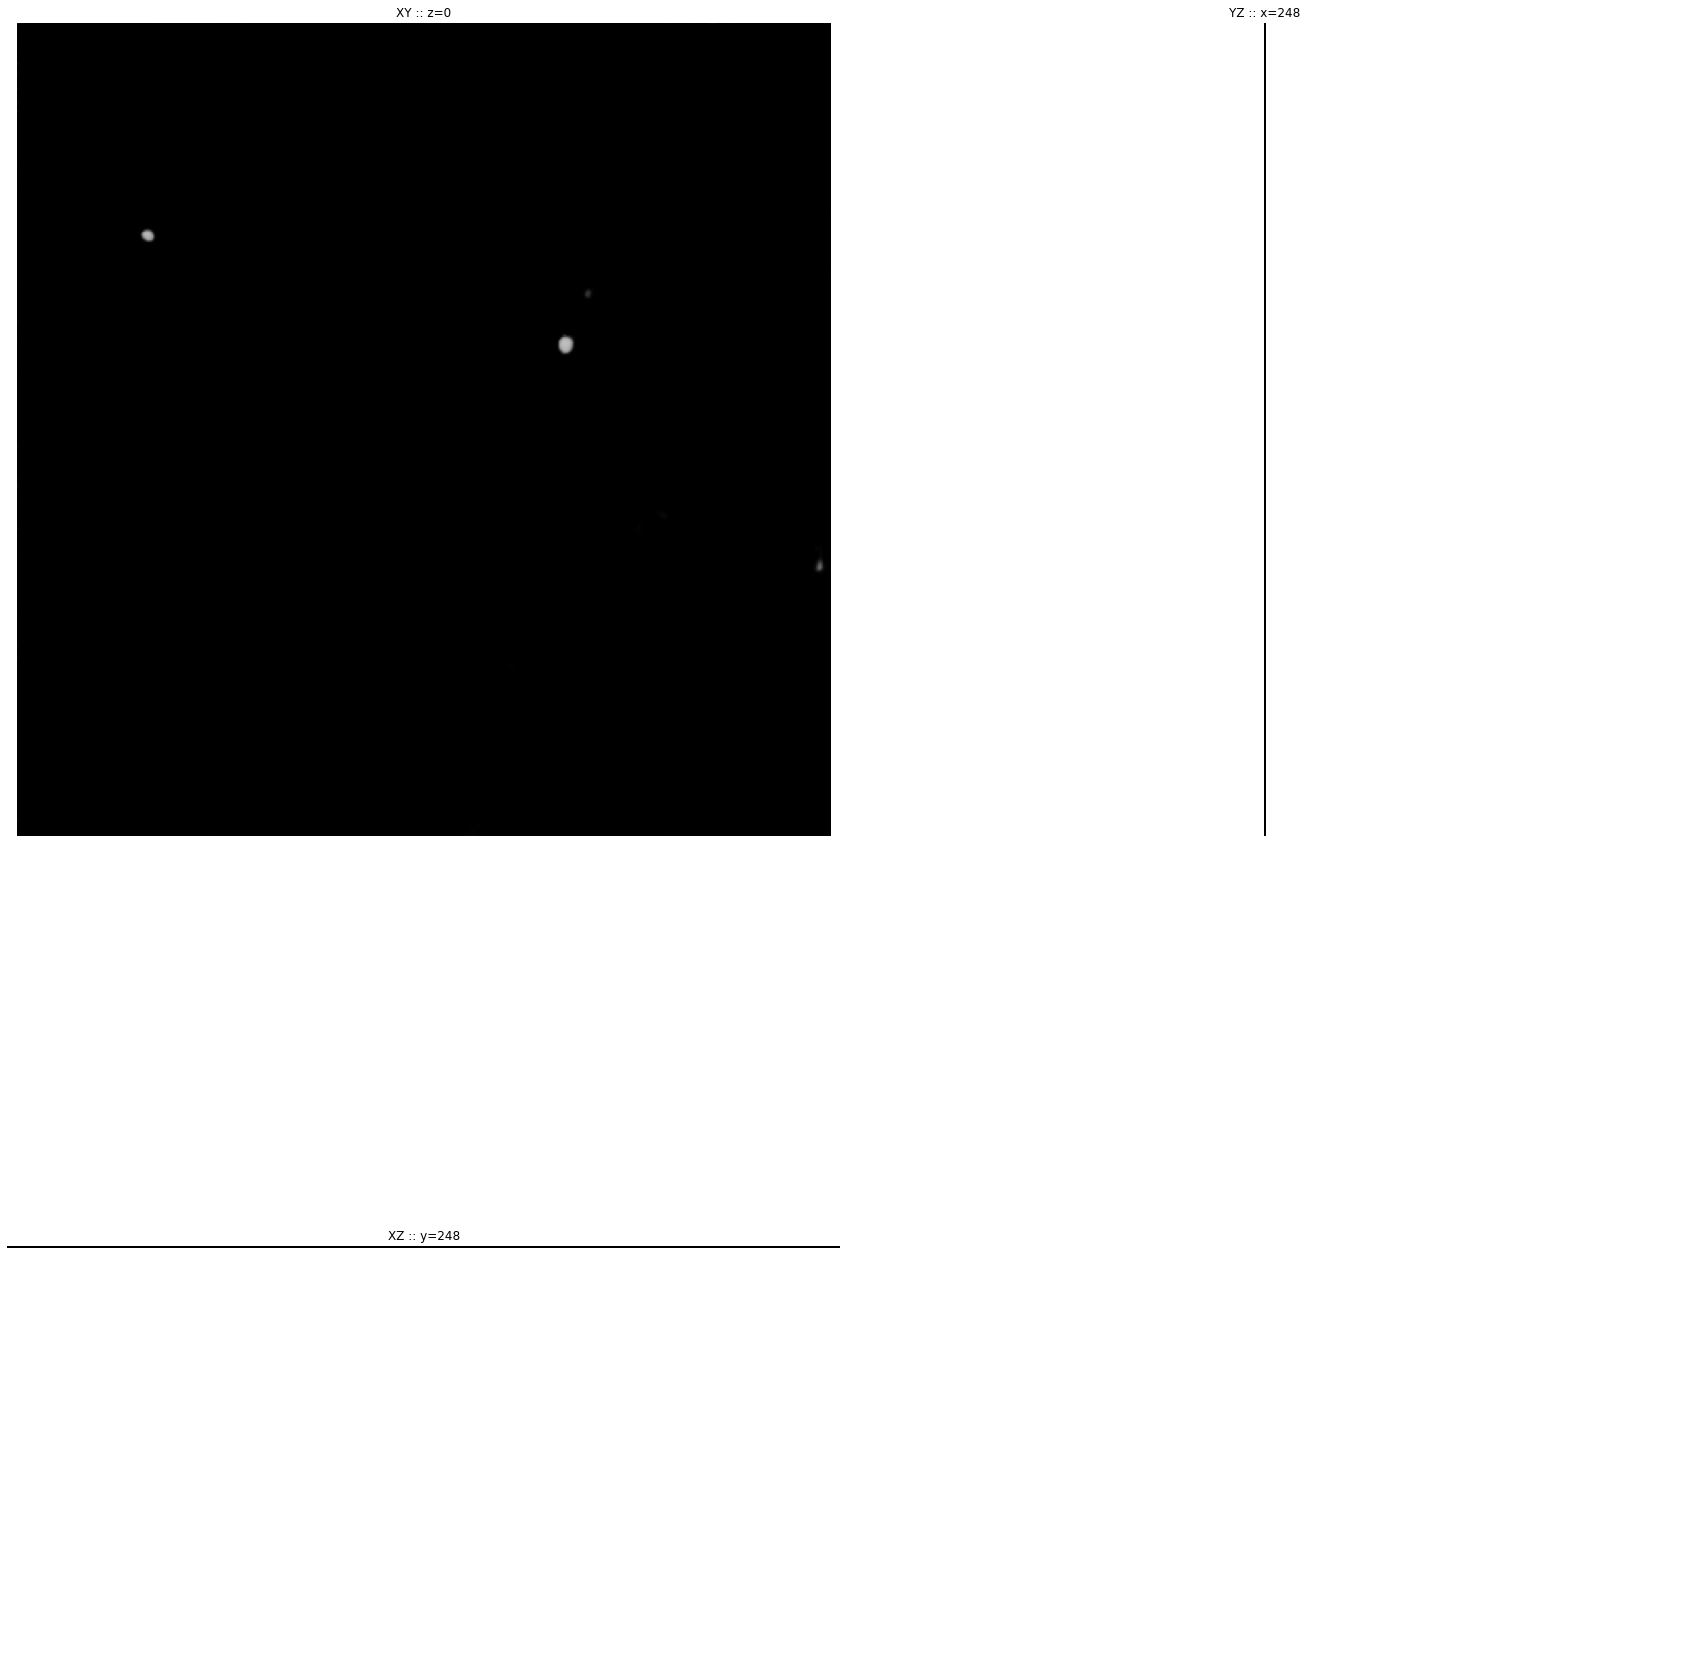

In [24]:
if debug__save_figs:
    logger.debug(f"Plotinng output probabilites of  {(n_crop_plots := 1)=} examples of 3d crops.")
    
    for n, (k, j, i) in enumerate(get_kji_iterator()):
                
        if n >= n_crop_plots:
            break
            
        logger.debug(f"{(ijk := (i, j, k))=}")
        
        if debug__materialize_crops:
            probas = proba_crops[i, j, k]
        else: 
            crop_coordinates = crops_coordinates[i, j, k]
            crop_data = crop_coord2data__data_loaded(crop_coordinates)
            # [model]
            model_in = crop_data.reshape(1, crop_shape[0], crop_shape[1], crop_shape[2]) / 255
            model_out = model.predict(model_in)
            # todo save me for debug/analysis
            probas = model_out.reshape(crop_probas_target_shape).astype(np.float32)  # not `probabilities_dtype` because the plot doesnt accept any type
            
        logger.debug(f"{probas.shape=}")

        for class_idx in range(n_classes):
            logger.debug(f"Saving figure {(fig_name := f'crop-{ijk}.probabilities.class={class_idx}.png')=}")    
            class_proba = probas[:, :, :, class_idx]
            
            # one class per line
            fig, axs = plt.subplots(
                nrows=2, ncols=2,
                figsize=((sz := 30), sz), 
                gridspec_kw={"wspace": (gridspace := .01), "hspace": .5 * gridspace},
            )
            for ax in axs.ravel():
                ax.axis("off")

            # normalized_voxels means the values are in [0, 1]
            viz.plot_orthogonal_slices(axs, class_proba, normalized_voxels=True)
        
            fig.savefig(
                fname=figs_dir / fig_name,
                dpi=300,
                **figs_common_kwargs,
                metadata={
                    "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
                    **figs_common_kwargs
                }
            )

[2020-10-30::13:58:21.032] tomo2seg :: DEBUG :: {<ipython-input-25-b432523f0841>:<module>:002}
Plotinng output predictions of  (n_crop_plots := 1)=1 examples of 3d crops.

[2020-10-30::13:58:21.034] tomo2seg :: DEBUG :: {<ipython-input-25-b432523f0841>:<module>:009}
(ijk := (i, j, k))=(0, 0, 0)

[2020-10-30::13:58:23.117] tomo2seg :: DEBUG :: {<ipython-input-25-b432523f0841>:<module>:023}
preds.shape=(496, 496, 1)

[2020-10-30::13:58:23.118] tomo2seg :: DEBUG :: {<ipython-input-25-b432523f0841>:<module>:025}
Saving figure (fig_name := f'crop-{ijk}.predictions.png')='crop-(0, 0, 0).predictions.png'

[2020-10-30::13:58:23.202] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:016}
volume.shape=(496, 496, 1)

[2020-10-30::13:58:23.203] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:020}
vmin, vmax=(0, 3)

[2020-10-30::13:58:23.204] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_slices:025}
No label mask given.

[2020-10-30::13:58:23.205] tomo2seg :: DEBUG :: {viz.py:plot_orthogonal_s

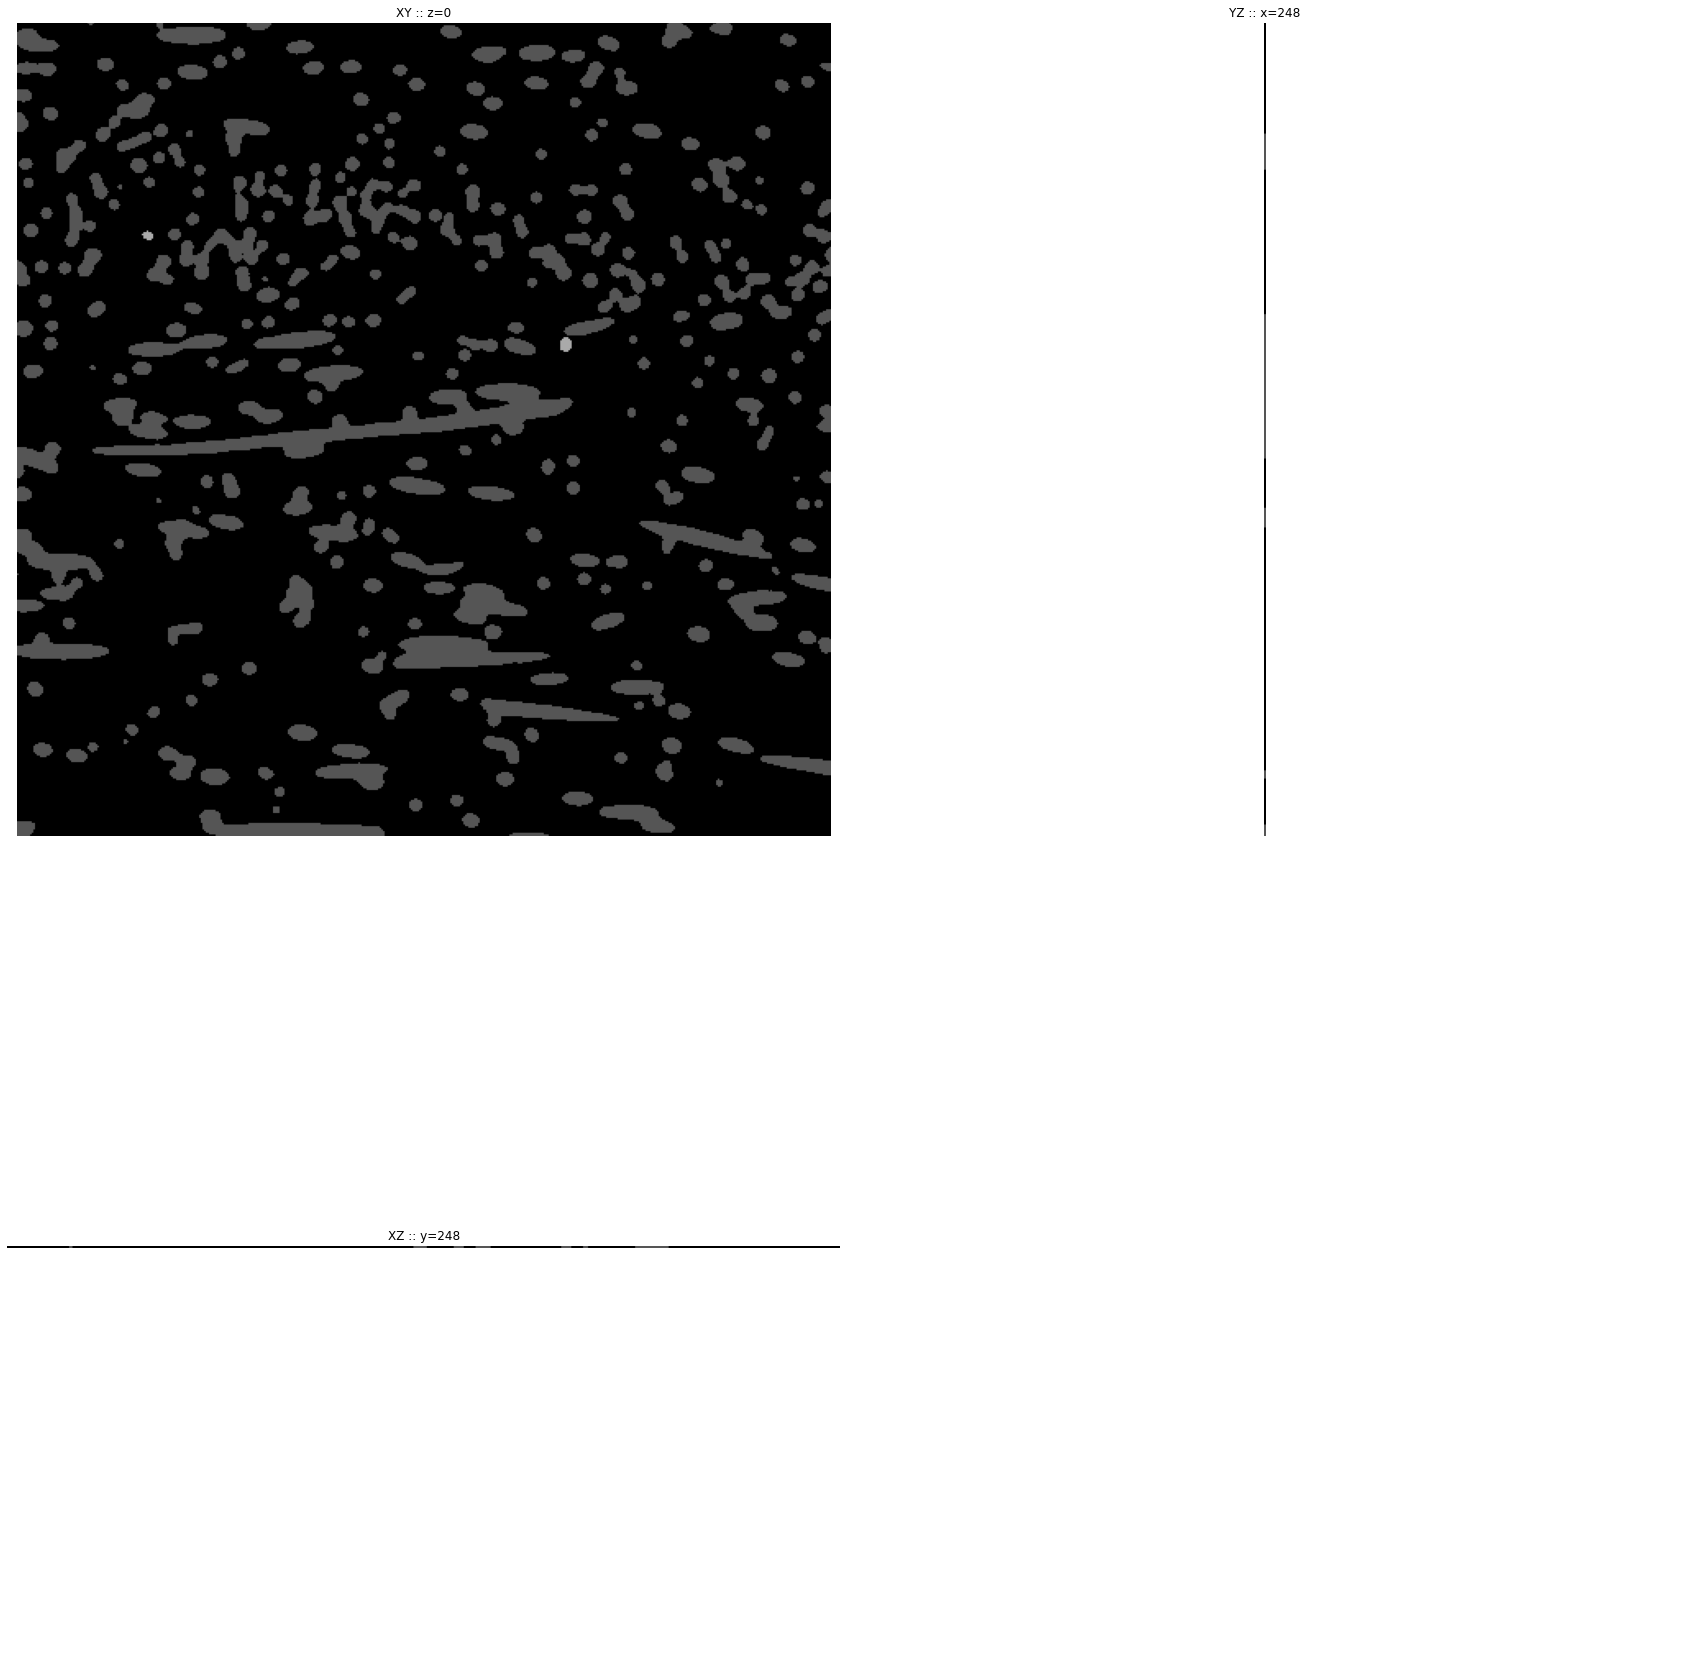

In [25]:
if debug__save_figs:
    logger.debug(f"Plotinng output predictions of  {(n_crop_plots := 1)=} examples of 3d crops.")
    
    for n, (k, j, i) in enumerate(get_kji_iterator()):
                
        if n >= n_crop_plots:
            break
            
        logger.debug(f"{(ijk := (i, j, k))=}")
        
        if debug__materialize_crops:
            preds = pred_crops[i, j, k]
        else: 
            crop_coordinates = crops_coordinates[i, j, k]
            crop_data = crop_coord2data__data_loaded(crop_coordinates)
            # [model]
            model_in = crop_data.reshape(1, crop_shape[0], crop_shape[1], crop_shape[2]) / 255
            model_out = model.predict(model_in)
            # todo save me for debug/analysis
            probas = model_out.reshape(crop_probas_target_shape).astype(probabilities_dtype)
            preds = probas.argmax(axis=-1).astype(np.int)
            
        logger.debug(f"{preds.shape=}")

        logger.debug(f"Saving figure {(fig_name := f'crop-{ijk}.predictions.png')=}")    

        # one class per line
        fig, axs = plt.subplots(
            nrows=2, ncols=2,
            figsize=((sz := 30), sz), 
            gridspec_kw={"wspace": (gridspace := .01), "hspace": .5 * gridspace},
        )
        for ax in axs.ravel():
            ax.axis("off")

        viz.plot_orthogonal_slices(axs, preds, vrange=(0, n_classes))

        fig.savefig(
            fname=figs_dir / fig_name,
            dpi=300,
            **figs_common_kwargs,
            metadata={
                "Title": f"vol={volume.fullname}::debug-fig::{fig_name}",
                **figs_common_kwargs
            }
        )

# Rebuild the volume

In [26]:
logger.debug(f"{(proba_volume_target_shape := list(volume_shape) + [n_classes])=}")

proba_volume = np.zeros(proba_volume_target_shape, dtype=probabilities_dtype)
logger.debug(f"{proba_volume.shape=}")

redundancies_count = np.zeros(proba_volume.shape).max(axis=-1).astype(np.int)  # only one channel
logger.debug(f"{redundancies_count.shape=}")

logger.debug(f"{(n_iterations := n_steps[0] * n_steps[1] * n_steps[2])=}")

if debug__materialize_crops:
    # 'F' reshapes with x varying fastest and z slowest
    # this is necessary bcs `crops_coordinates_sequential` is 
    # also reshaped like this
    proba_crops_sequential = proba_crops.reshape(-1, *proba_crops.shape[3:], order='F')  
    logger.debug(f"{proba_crops_sequential.shape=}")

    logger.debug("Summing up the crops' probabilities.")
    for coord, proba_crop in pbar(zip(
        crops_coordinates_sequential,
        proba_crops_sequential,
    ), prefix="sum-probas", max_value=n_iterations):
        (x0, x1), (y0, y1), (z0, z1) = coord
        proba_volume[x0:x1, y0:y1, z0:z1] += proba_crop
        redundancies_count[x0:x1, y0:y1, z0:z1] += np.ones(crop_shape, dtype=np.int)
else:
    logger.debug("Predicting and summing up the crops' probabilities.")
    for coord in pbar(crops_coordinates_sequential, prefix="predict-and-sum-probas", max_value=n_iterations):
        # [model]
        (x0, x1), (y0, y1), (z0, z1) = coord
        crop_data = crop_coord2data__data_loaded(coord)
        modelin = crop_data.reshape(1, crop_shape[0], crop_shape[1], 1) / 255  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        modelout = model.predict(modelin, batch_size=1)  # todo batched version
        crop_probas = modelout.reshape(crop_probas_target_shape).astype(probabilities_dtype)
        proba_volume[x0:x1, y0:y1, z0:z1] += crop_probas
        redundancies_count[x0:x1, y0:y1, z0:z1] += np.ones(crop_shape, dtype=np.int)
        
# check that the min and max probas are coherent with the min/max redundancy
logger.debug(f"{(min_proba_sum := proba_volume.min(axis=0).min(axis=0).min(axis=0))=}")
logger.debug(f"{(max_proba_sum := proba_volume.max(axis=0).max(axis=0).max(axis=0))=}")

logger.debug(f"{(min_redundancy := np.min(redundancies_count))=}")
logger.debug(f"{(max_redundancy := np.max(redundancies_count))=}")

assert np.all(min_proba_sum >= 0)
assert np.all(max_proba_sum <= max_redundancy)

# divide each probability channel by the number of times it was summed (avg proba)
logger.debug(f"Dividing probability redundancies.")
for klass_idx in pbar(range(n_classes), max_value=n_classes, prefix="redundancies-per-class"):
    proba_volume[:, :, :, klass_idx] = proba_volume[:, :, :, klass_idx] / redundancies_count

# check that proba distribs sum to 1
logger.debug(f"{(min_proba := proba_volume.min(axis=0).min(axis=0).min(axis=0))=}")
logger.debug(f"{(max_proba := proba_volume.max(axis=0).max(axis=0).max(axis=0))=}")

assert np.all(min_proba >= 0)
assert np.all(max_proba <= 1)

logger.debug(f"{(min_distrib_proba_sum := proba_volume.sum(axis=-1).min())=}")
logger.debug(f"{(max_distrib_proba_sum := proba_volume.sum(axis=-1).max())=}")

assert np.isclose(min_distrib_proba_sum, 1, atol=.001)
assert np.isclose(max_distrib_proba_sum, 1, atol=.001)

pred_volume = proba_volume.argmax(axis=-1).astype("uint8")

logger.debug(f"{pred_volume.shape=}   {pred_volume.min()=}   {pred_volume.max()=}")

[2020-10-30::13:58:27.218] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:001}
(proba_volume_target_shape := list(volume_shape) + [n_classes])=[500, 500, 500, 3]

[2020-10-30::13:58:27.219] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:004}
proba_volume.shape=(500, 500, 500, 3)

[2020-10-30::13:58:33.265] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:007}
redundancies_count.shape=(500, 500, 500)

[2020-10-30::13:58:33.266] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:009}
(n_iterations := n_steps[0] * n_steps[1] * n_steps[2])=2000

[2020-10-30::13:58:33.267] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:027}
Predicting and summing up the crops' probabilities.



100% (2000 of 2000) |####################| Elapsed Time: 1:02:08 Time:  1:02:08


[2020-10-30::15:00:44.806] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:039}
(min_proba_sum := proba_volume.min(axis=0).min(axis=0).min(axis=0))=array([0., 0., 0.], dtype=float16)

[2020-10-30::15:00:48.266] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:040}
(max_proba_sum := proba_volume.max(axis=0).max(axis=0).max(axis=0))=array([4.   , 4.   , 3.246], dtype=float16)

[2020-10-30::15:00:48.411] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:042}
(min_redundancy := np.min(redundancies_count))=1

[2020-10-30::15:00:48.551] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:043}
(max_redundancy := np.max(redundancies_count))=4

[2020-10-30::15:00:48.552] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:049}
Dividing probability redundancies.



100% (3 of 3) |##########################| Elapsed Time: 0:00:16 Time:  0:00:16


[2020-10-30::15:01:07.714] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:054}
(min_proba := proba_volume.min(axis=0).min(axis=0).min(axis=0))=array([0., 0., 0.], dtype=float16)

[2020-10-30::15:01:10.869] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:055}
(max_proba := proba_volume.max(axis=0).max(axis=0).max(axis=0))=array([1.    , 1.    , 0.8115], dtype=float16)

[2020-10-30::15:01:17.540] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:060}
(min_distrib_proba_sum := proba_volume.sum(axis=-1).min())=0.999

[2020-10-30::15:01:24.417] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:061}
(max_distrib_proba_sum := proba_volume.sum(axis=-1).max())=1.001

[2020-10-30::15:01:27.726] tomo2seg :: DEBUG :: {<ipython-input-26-138e760e9826>:<module>:068}
pred_volume.shape=(500, 500, 500)   pred_volume.min()=0   pred_volume.max()=2





# Save volumes

In [30]:
exec_time = int(exec_time)
exec_time

1604062659

In [28]:
execution_name

'16.04.06.26.59'

In [43]:
estimation_volume = EstimationVolume.from_objects(volume=volume, model=model)

for k, v in [
    ("exec_time", exec_time),
    ("exec_name", execution_name)
]:
    estimation_volume.write_metadata(k, v)

[2020-10-30::15:40:22.423] tomo2seg :: DEBUG :: {data.py:write_metadata:254}
Writing to metadata file at `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.metadata.yml`

[2020-10-30::15:40:22.426] tomo2seg :: DEBUG :: {data.py:write_metadata:254}
Writing to metadata file at `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.metadata.yml`



In [44]:
logger.debug(f"Writing probabilities on disk at `{estimation_volume.probabilities_path}`")
np.save(estimation_volume.probabilities_path, proba_volume)

[2020-10-30::15:43:26.547] tomo2seg :: DEBUG :: {<ipython-input-44-44f44423fa35>:<module>:001}
Writing probabilities on disk at `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.probabilities.npy`



In [47]:
logger.debug(f"Writing predictions on disk at `{(str_path := str(estimation_volume.predictions_path))}`")
file_utils.HST_write(pred_volume, str_path)

[2020-10-30::15:45:29.342] tomo2seg :: DEBUG :: {<ipython-input-47-35bfd9a3b9cd>:<module>:001}
Writing predictions on disk at `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.predictions.raw`

opening /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.predictions.raw for writing in mode w
volume size is 500x500x500
data type is uint8
writing .info file
done with writing


In [50]:
if save_probas_by_class:
    for klass_idx in volume.metadata.labels:
        logger.debug(f"Writing probabilities of class `{klass_idx}` on disk at `{(str_path := str(estimation_volume.get_class_probability_path(klass_idx)))=}`")
        file_utils.HST_write(proba_volume[:, :, :, klass_idx], str_path)

[2020-10-30::15:49:00.618] tomo2seg :: DEBUG :: {data.py:metadata:132}
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.metadata.yml`.

[2020-10-30::15:49:00.623] tomo2seg :: DEBUG :: {<ipython-input-50-55d7deeffff3>:<module>:003}
Writing probabilities of class `0` on disk at `(str_path := str(estimation_volume.get_class_probability_path(klass_idx)))='/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.probability.class_idx=0.raw'`

opening /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.probability.class_idx=0.raw for writing in mode w
volume size is 500x500x500
data type is float16
writing .info file
done with writing
[2020-10-30::15:49:03.395] tomo2seg :: DEBUG :: {data.py:metadata:132}
Loading metadata from `/home/joaopcbertoldo/pro